In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import time

In [2]:
with open('screen_info.txt','rb') as fl:
    t = pickle.load(fl)
fnames = t[0]
totf = t[1]
binf = t[2]
runfile = 0
fname = fnames[runfile]
bf = binf[runfile]

In [3]:
path = os.getcwd() + '/bioassay-datasets/'
p_fingerprints = []
c_fingerprints = []
labels = []
with open(path+fname+'red_train.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints.append(row[:bf])
        c_fingerprints.append(row[bf:-1])
        labels.append(row[-1])

In [4]:
print(np.asarray(p_fingerprints)[1:].shape)

p_fingerprints = np.asarray(p_fingerprints)[1:]
p_fingerprints = p_fingerprints.astype(int)
c_fingerprints = np.asarray(c_fingerprints)[1:]
c_fingerprints = c_fingerprints.astype(float)
#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = p_fingerprints.shape
ip_dim2 = c_fingerprints.shape[1]
labels = labels[1:]
print(no_examples,ip_dim)
print(ip_dim2)
#p_fingerprints[(p_fingerprints==0)] = -1

(3423, 112)
(3423, 112)
32


In [5]:
labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0
labels2 = labels2.astype(int)

In [6]:
ind = np.arange(no_examples)
np.random.shuffle(ind)
p_fingerprints = p_fingerprints[ind]
c_fingerprints = c_fingerprints[ind]
labels2 = labels2[ind]

no_active_ele = (sum(labels2))
print(no_active_ele)

[48]


In [7]:
def get_train_batch(batch_size,validation_iter=0,binary=True):
    
    if validation_iter == 0: #no validation
        curr_data_size = no_examples
        labels_train = labels2
    else:
        curr_data_size = int(no_examples*0.8)
        interval_size = int(no_examples*0.2)
        
        if(val_iter==1):
            s_ind1 = int((validation_iter)*interval_size)
            end_ind1 = int((validation_iter+1)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        else:
            s_ind1 = 0
            end_ind1 = int((validation_iter)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        
        indices = range(s_ind1,end_ind1) + range(s_ind2,end_ind2)
        c_train_data = c_fingerprints[indices]
        p_train_data = p_fingerprints[indices]
        labels_train = labels2[indices]
                               
    samples = np.random.randint(low=0,high=curr_data_size,size=(batch_size,1))
    if binary == True:
        train_batch = p_fingerprints[samples].reshape(batch_size,ip_dim)
        train_batch = train_batch.astype(int)
    else:
        train_batch = c_fingerprints[samples].reshape(batch_size,ip_dim2)
        train_batch = train_batch.astype(float)
    
    train_batch = torch.cuda.FloatTensor(train_batch)
    train_batch = Variable(train_batch,requires_grad=False).cuda()
    target = Variable(torch.cuda.LongTensor(labels_train[samples]),requires_grad=False)
    target = target.view(batch_size,)
    return train_batch,target

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [9]:
batch_size = 96
#ip_dim = 28*28
z_dim = 50

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
print len(train_loader), len(test_loader)

625 105


In [11]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        
        self.l1 = nn.Linear(ip_dim,800)
        self.l2 = nn.Linear(800,500)
        #self.l3 = nn.Linear(500,500)
        self.l41 = nn.Linear(500,100)
        self.l42 = nn.Linear(500,100)
        self.l51 = nn.Linear(100,z_dim)
        self.l52 = nn.Linear(100,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        #x = F.leaky_relu(self.l3(x))
        x1 = F.leaky_relu(self.l41(x))
        x1 = self.l51(x1)
        x2 = F.leaky_relu(self.l42(x))
        x2 = self.l52(x2)
        
        return x1,x2

In [12]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,100)
        self.l2 = nn.Linear(100,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

In [13]:
cuda = True
if(cuda):
    E = encoder().cuda()
    D = decoder().cuda()
else:
    E = encoder()
    D = decoder()

In [14]:
def clear_grad():
    E.zero_grad()
    D.zero_grad()

In [15]:
E_optim = optim.Adam(E.parameters(),lr = 1e-3)
D_optim = optim.Adam(D.parameters(),lr = 1e-3)

0.0799727886915 0.11793487519
0.0799727886915 0.0832386463881
0.0643179863691 0.0515501759946
0.0643179863691 0.0529303252697
0.0624163150787 0.0378569923341
0.0624163150787 0.0215667691082
0.0601181425154 0.0179351121187
0.0601181425154 0.0181206278503
0.0574544109404 0.0152160264552


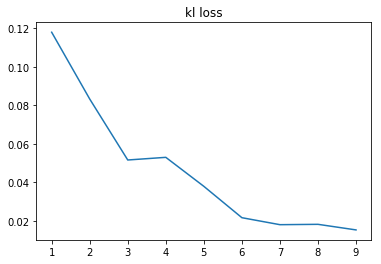

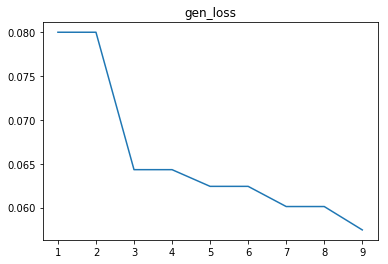

0.0574544109404 0.012600723654
0.0588177740574 0.00979943759739
0.0588177740574 0.00818189140409
0.0573494099081 0.0069487709552
0.0573494099081 0.00625197729096
0.0587816350162 0.00451835989952
0.0587816350162 0.00456102238968
0.0549925379455 0.00432254839689
0.0549925379455 0.00466649234295
0.0565045885742 0.0040336525999


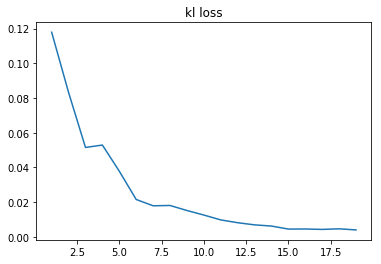

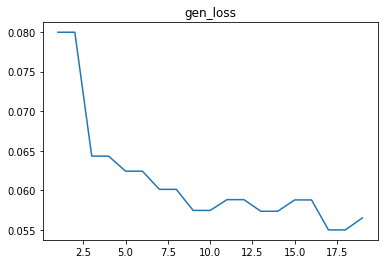

0.0565045885742 0.0034353886731
0.0533530935645 0.00290625588968
0.0533530935645 0.0026429486461
0.0510091967881 0.00233228015713
0.0510091967881 0.00206641829573
0.051587741822 0.00150477082934
0.051587741822 0.00155285873916
0.0551790632308 0.00143985822797
0.0551790632308 0.00162842660211
0.0536723546684 0.00140229368117


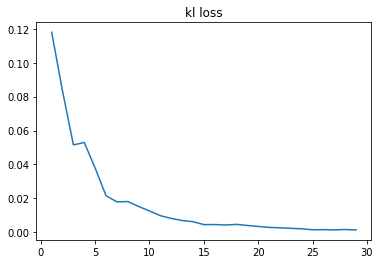

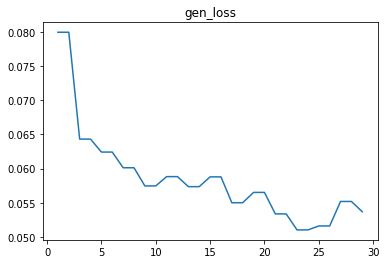

0.0536723546684 0.00119255145546
0.0547861494124 0.00081595312804
0.0547861494124 0.000810452154838
0.0528302639723 0.000800450041424
0.0528302639723 0.000976380310021
0.0530850365758 0.000742871023249
0.0530850365758 0.00056686316384
0.052859313786 0.000531848229002
0.052859313786 0.000606822199188
0.0560081228614 0.000599235296249


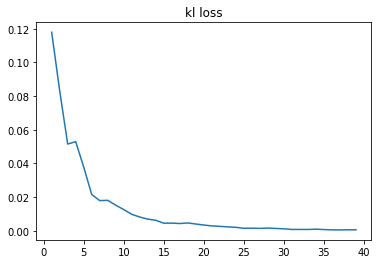

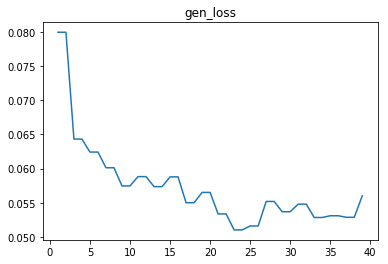

0.0560081228614 0.000477554276586
0.0507599003613 0.000379408098524
0.0507599003613 0.000385073944926
0.0527841374278 0.000423427671194
0.0527841374278 0.000454869761597
0.0482862219214 0.000367694854503
0.0482862219214 0.000302479922539
0.0526759512722 0.000285898975562
0.0526759512722 0.000372715003323
0.0518292188644 0.000353034294676


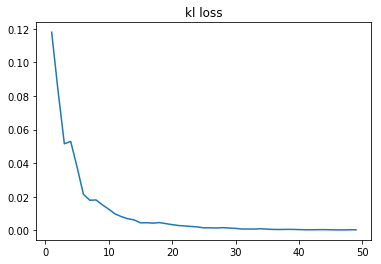

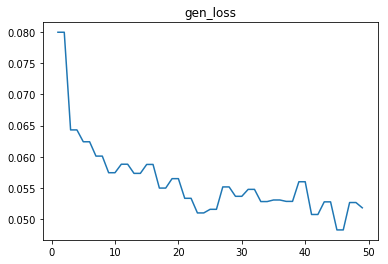

0.0518292188644 0.000269604555797
0.0552712343633 0.000221574373427
0.0552712343633 0.000286630063783
0.0522652864456 0.000267035647994
0.0522652864456 0.00033408156014
0.0498042963445 0.000240874171141
0.0498042963445 0.00016088722623
0.0514967367053 0.000202267750865
0.0514967367053 0.000263762980467
0.0537639781833 0.000245046190685


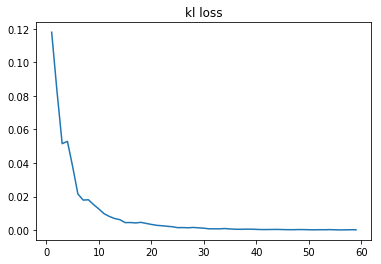

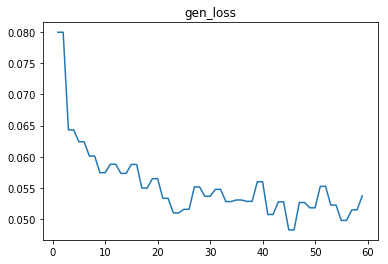

0.0537639781833 0.00017500235117
0.051574729383 0.000143447279697
0.051574729383 0.00021300962544
0.0524994470179 0.00021006478346
0.0524994470179 0.000183132171514
0.0520965084434 0.000139533542097
0.0520965084434 0.000154382549226
0.0519129447639 0.000158349372214
0.0519129447639 0.00020169839263
0.0568368248641 0.000186890683835


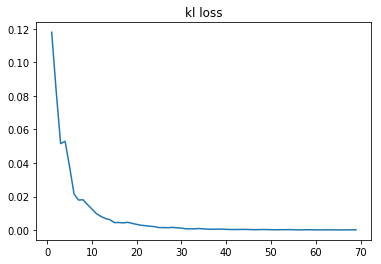

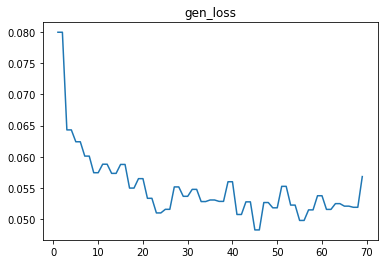

0.0568368248641 0.00013814898557
0.0499290674925 0.000125329941511
0.0499290674925 0.000188402831554
0.0515225045383 0.00017668804503
0.0515225045383 0.000192406281712
0.053033914417 0.000131629727548
0.053033914417 0.000171388193849
0.0522087812424 0.000193888947251
0.0522087812424 0.00015530953533
0.0574950166047 0.000120234057249


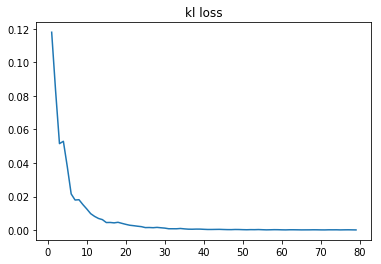

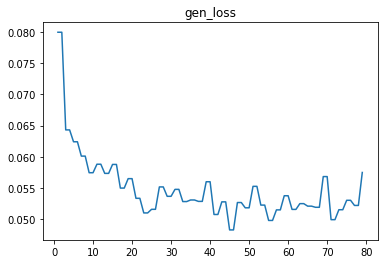

0.0574950166047 0.000140054151416
0.0509751923382 0.000171171821421
0.0509751923382 0.000159932926181
0.0533668138087 0.000115120477858
0.0533668138087 0.000124762766063
0.0502342283726 0.000148212857312
0.0502342283726 0.000171125255292
0.053078468889 0.000136277638376
0.053078468889 9.27917062654e-05
0.0534250326455 0.000124733589473


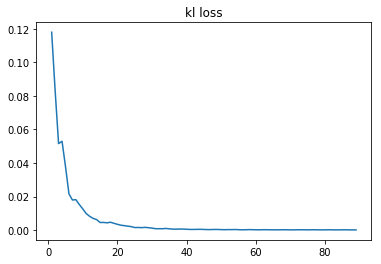

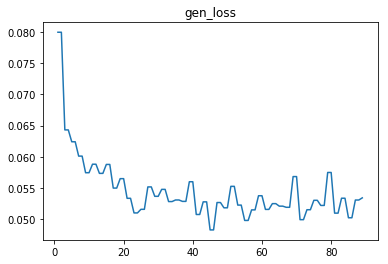

0.0534250326455 0.000211378879612
0.0514813773334 0.000141849130159
0.0514813773334 8.75586047187e-05
0.0563745424151 0.000116842493298
0.0563745424151 0.000205728851142
0.0519896969199 0.000164530239999
0.0519896969199 8.95410776138e-05
0.0505995824933 9.56552103162e-05
0.0505995824933 0.000196724518901


In [16]:
epochs = 100
kl_track= []
gen_track = []
for ep in range(2,epochs):
    #for idx,(x,label) in enumerate(train_loader):
    if(1==1):
        x,target = get_train_batch(batch_size,validation_iter = 0)
        
        if(cuda):
        #    x = Variable(x.cuda())
            z = Variable(torch.randn(batch_size,z_dim)).cuda()
        else:
         #   x = Variable(x)
            z = Variable(torch.randn(batch_size,z_dim))            
        #x = x.view(batch_size,28*28)
        
        
        mu,logvar = E(x)
        sig = torch.sqrt(torch.exp(logvar))
        zhat = mu + torch.mul(z,sig)
        xhat = D(zhat)
        
        if(ep%2==0):
            gen_loss = nn.MSELoss()(xhat,x)
            gen_loss.backward(retain_graph = True)
            D_optim.step()
            E_optim.step()
            clear_grad()
        
        ## KL Loss ##
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= batch_size
        
        KLD.backward()
        E_optim.step()
        clear_grad()
        
    print gen_loss.data[0],KLD.data[0]
    kl_track.append(KLD.data[0])
    gen_track.append(gen_loss.data[0])
    
    if(ep%10==0):
#         z = Variable(torch.randn(1,z_dim).cuda())
#         op = D(z).view(28,28)
#         op = op.cpu().data.numpy()
#         plt.imshow(op)
#         plt.show()
        plt.plot(range(1,ep),kl_track)
        plt.title('kl loss')
        plt.show()
        plt.plot(range(1,ep),gen_track)
        plt.title('gen_loss')
        plt.show()

In [17]:
tic = time.time()
z_encoded,sig = E(Variable(torch.cuda.FloatTensor(p_fingerprints)))
toc = time.time()
print(toc-tic)

# z_mu = z_encoded.cpu().data.numpy()

# plt.figure(figsize=(8, 6)) 
# plt.scatter(z_mu[:, 0], z_mu[:, 1], c=labels2)
# plt.colorbar()
# plt.grid()
# plt.show()

0.868973970413


In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.l1 = nn.Linear(z_dim,300)
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,300)
        self.l4 = nn.Linear(300,100)
        self.l5 = nn.Linear(100,2)
        
    def forward(self,x):
        x = F.selu(self.l1(x))
        x = F.selu(self.l2(x))
        x = F.selu(self.l3(x))
        x = F.relu(self.l4(x))
        x = (self.l5(x))
        
        return x

In [28]:
def sample_z(size):
    ind = torch.cuda.LongTensor(torch.randperm(no_examples)[:size].numpy())
    return z_encoded[ind], Variable(torch.cuda.LongTensor(labels2)[ind],requires_grad = False)

In [29]:
def gen_disc_model(w):
    d = Discriminator().cuda()
    d_optim = optim.Adam(d.parameters(),lr=1e-4,weight_decay=1e-2)
    d = train_disc(d,d_optim,w)
    return d

In [30]:
def train_disc(d,d_optim,w):
    for ep in range(2000):
        d_optim.zero_grad()
        x,true_l = sample_z(batch_size)
        true_l = true_l.view(true_l.size()[0],)
        p_labels = d(x)
        weights = torch.Tensor([1,w]).cuda()
        criteria = nn.CrossEntropyLoss(weight=weights)
        true_l = true_l.type(torch.cuda.LongTensor)
        loss = criteria(p_labels,true_l)
        loss.backward(retain_graph=True)
        d_optim.step()
        
        if(ep%50==49):
            print(loss.data[0])
            
    return d

In [32]:
weights = np.linspace(25,50,5)
for w in weights:
    print("w: ",w)
    d = gen_disc_model(w)
    train_op = d(z_encoded).cpu().data.numpy()
    train_op = np.argmax(train_op,axis=1)
    cf = metrics.confusion_matrix(labels2,train_op)
    [tn, fp, fn, tp]  = cf.ravel()
    print('tn, fp, fn, tp: ',cf.ravel())

('w: ', 25.0)
0.645637750626
0.31165471673
0.777122199535
0.682859122753
0.516191661358
0.513958096504
0.27379450202
0.512196362019
0.299992382526
0.511625051498
0.513648211956
0.31862232089
0.513468503952
0.240765690804
0.518689393997
0.511880755424
0.649577200413
0.791330873966
0.796363353729
0.513958156109
0.512046456337
0.276923745871
0.514038205147
0.514306604862
0.664870560169
0.2846378088
0.886204242706
0.311472982168
0.786005020142
0.262101203203
0.319634467363
0.522282838821
0.682291030884
0.771033406258
0.678224682808
0.514639556408
0.315775036812
0.674349248409
0.237595140934
0.2209700495
('tn, fp, fn, tp: ', array([3375,    0,   48,    0]))
('w: ', 31.25)
0.562907457352
0.700580120087
0.57297450304
0.566447734833
0.837263762951
0.324005573988
0.274885267019
0.270909279585
0.310652256012
0.740961670876
0.695597171783
0.332674503326
0.699290513992
0.564300477505
0.561591207981
0.690027296543
0.681153357029
0.729576766491
0.32646843791
0.367807000875
0.559892594814
0.695487916

In [ ]:
z_encoded.dtype